# **Meng Import library yang dibutuhkan**

In [2]:
# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import Xception


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# **Meng ekstrak file .zip**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Meng ekstrak file data.zip
import zipfile
import os
local_zip = '/content/drive/MyDrive/weather.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **MEMPERSIAPKAN DATA**

In [5]:
data_dir = '/content/weather'
target_size = (150, 150)

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(data_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        file_name.append(name)

# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

df.head()

,path,file_name,tag
0,/content/weather/foggy/foggy (470).jpg,foggy (470).jpg,foggy
1,/content/weather/foggy/foggy (438).jpg,foggy (438).jpg,foggy
2,/content/weather/foggy/foggy (612).jpg,foggy (612).jpg,foggy
3,/content/weather/foggy/foggy (763).jpg,foggy (763).jpg,foggy
4,/content/weather/foggy/foggy (434).jpg,foggy (434).jpg,foggy


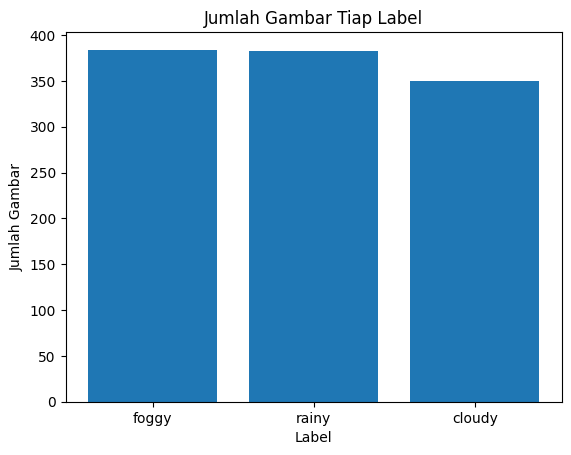

In [6]:
# Menghitung jumlah gambar per label
number_label = df['tag'].value_counts()

# Visualisasi jumlah gambar tiap label
plt.bar(number_label.index, number_label.values)
plt.title('Jumlah Gambar Tiap Label')
plt.xlabel('Label')
plt.ylabel('Jumlah Gambar')
plt.show()

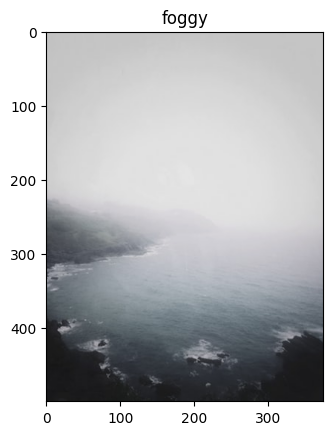

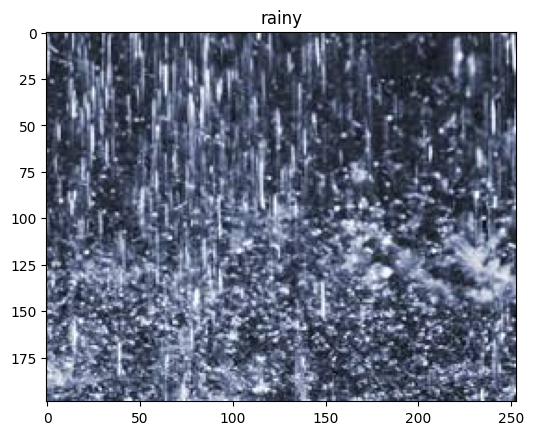

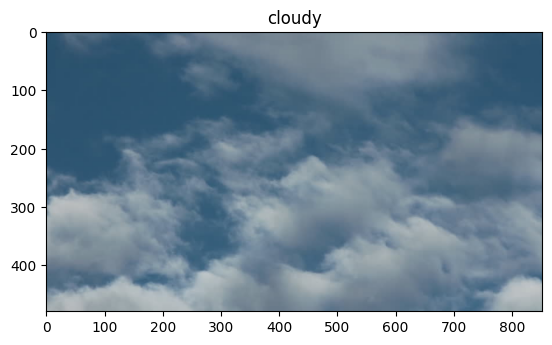

In [7]:
# Menampilkan sampel gambar dari tiap kelas
img_each_class = 1
img_samples = {}
classes = list(number_label.keys())

for c in classes:
    temp = os.listdir(os.path.join(data_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(data_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

#**MEMBAGI DATA MENJADI DATA TRAIN 80% DAN DATA TEST 20%**

In [8]:
# Menentukan variabel X dan y
X = df['path']
y = df['tag']

# Membagi data menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# kemudian data test dibagi menjadi 2 sehingga menjadi data test dan data validation.
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [9]:
# menyatukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train,
                         'tag':y_train,
                         'set':'train'})

df_test = pd.DataFrame({'path':X_test,
                        'tag':y_test,
                        'set':'test'})

df_val = pd.DataFrame({'path':X_val,
                       'tag':y_val,
                       'set':'validation'})

df_all = pd.concat([df_train, df_test, df_val]).reset_index(drop=True)


print('Total image          : ', len(df_all))
print('Total train image    : ', len(df_train))
print('Total test image     : ', len(df_test))
print('Total validasi image : ', len(df_val))

Total image          :  1117
Total train image    :  893
Total test image     :  112
Total validasi image :  112


# **MASUKKAN DATA KE FOLDER SET MASING - MASING**

In [11]:
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = '/content/weather'
dataset_path = 'dataset/'

for index, row in tq(df_all.iterrows()):

    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])

    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)

    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **LATIH DATA DAN DATA AUGMENTASI**

# DATA AUGMENTASI

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1./255
)

val_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [13]:
train_generator= train_datagen.flow_from_directory(
    'dataset/train/',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    batch_size = 32)

val_generator= val_datagen.flow_from_directory(
    'dataset/validation/',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle = True,
    batch_size = 32)

Found 893 images belonging to 3 classes.
Found 112 images belonging to 3 classes.


## **MEMBANGUN MODEL**

# MENGGUNAKAN ARSITEKTUR Xception

In [17]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=(150, 150, 3))

83683744/83683744 [==============================] - 3s 0us/step


In [18]:
#Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Tambahkan custom layers di atasnya
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 2048)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 3)                 24579     
                                                                 
Total params: 20886059 (79.67 MB)
Trainable params: 24579 (96.01 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


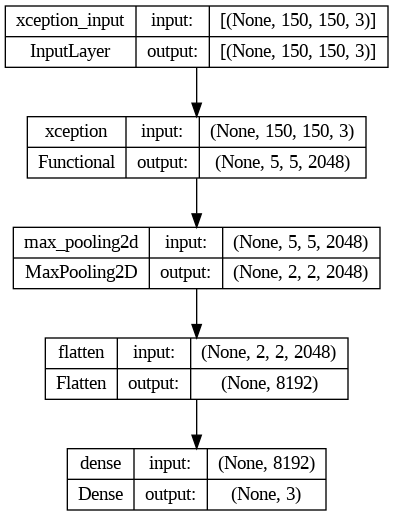

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [22]:
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

In [23]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
28/28 [==============================] - 109s 4s/step - loss: 0.6370 - accuracy: 0.7615 - val_loss: 0.3230 - val_accuracy: 0.8750
Epoch 2/10
28/28 [==============================] - 106s 4s/step - loss: 0.2324 - accuracy: 0.9205 - val_loss: 0.2456 - val_accuracy: 0.8929
Epoch 3/10
28/28 [==============================] - 108s 4s/step - loss: 0.1420 - accuracy: 0.9642 - val_loss: 0.2004 - val_accuracy: 0.9196
Epoch 4/10
28/28 [==============================] - 120s 4s/step - loss: 0.0992 - accuracy: 0.9776 - val_loss: 0.1584 - val_accuracy: 0.9375
Epoch 5/10
28/28 [==============================] - 96s 3s/step - loss: 0.0821 - accuracy: 0.9821 - val_loss: 0.1621 - val_accuracy: 0.9464
Epoch 6/10
28/28 [==============================] - 86s 3s/step - loss: 0.0616 - accuracy: 0.9933 - val_loss: 0.1712 - val_accuracy: 0.9107
Epoch 7/10
28/28 [==============================] - 83s 3s/step - loss: 0.0528 - accuracy: 0.9944 - val_loss: 0.1532 - val_accuracy: 0.9464
Epoch 8/10
28/28

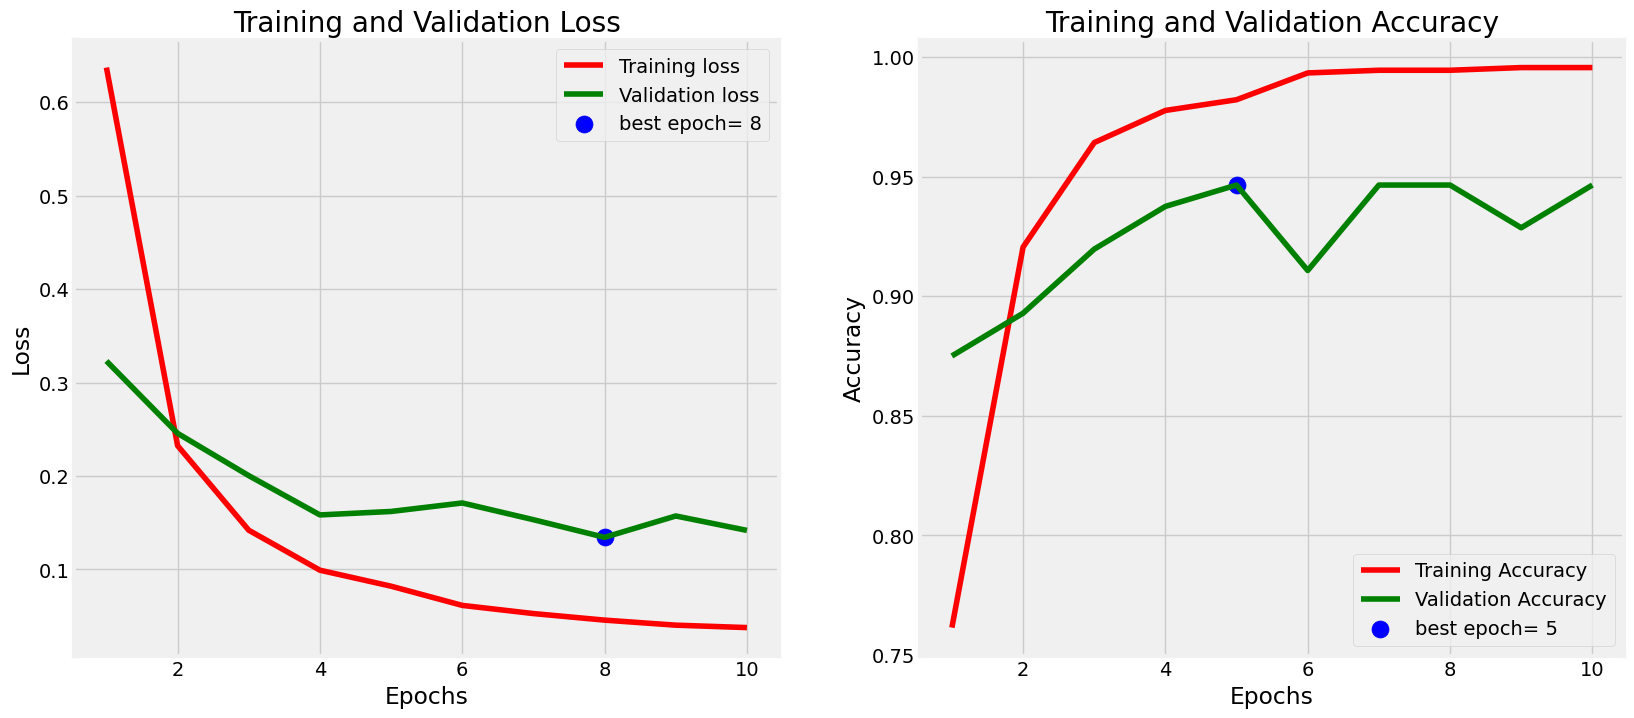

In [24]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [25]:
val_loss, val_accuracy = model.evaluate(val_generator)

4/4 [==============================] - 10s 3s/step - loss: 0.1418 - accuracy: 0.9464


# **TESTING DATA**

In [26]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator= test_datagen.flow_from_directory(
    'dataset/test/',
    target_size=(150,150),
    shuffle = False,
    batch_size = 32)

test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 112 images belonging to 3 classes.
4/4 [==============================] - 10s 3s/step - loss: 0.2233 - accuracy: 0.9375
Test Accuracy : 93.75%
Test Loss     : 0.223


# **MENGEVALUASI MODEL**

4/4 [==============================] - 12s 2s/step


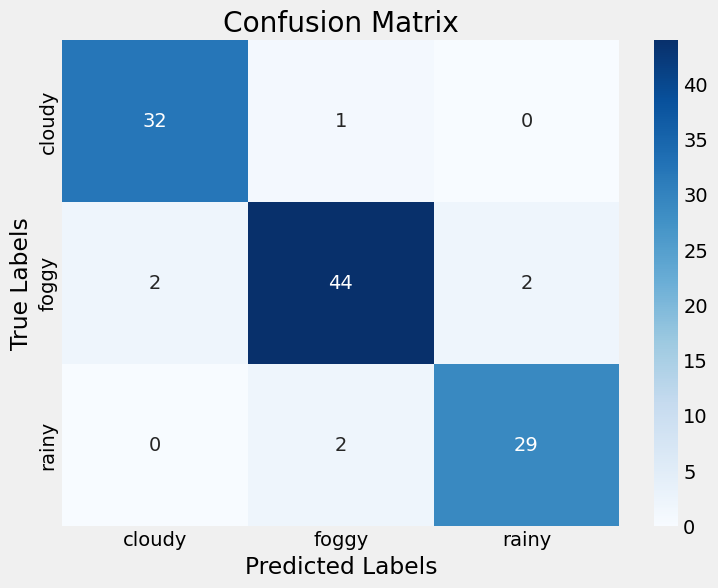

In [31]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels= class_labels,
            yticklabels= class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
class_report = classification_report(y_true, y_pred_classes, target_names=class_labels)

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

      cloudy       0.94      0.97      0.96        33
       foggy       0.94      0.92      0.93        48
       rainy       0.94      0.94      0.94        31

    accuracy                           0.94       112
   macro avg       0.94      0.94      0.94       112
weighted avg       0.94      0.94      0.94       112



In [38]:
model.save('model.h5')
print('model saved as model.h5')

model saved as model.h5
